<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 💻 02 - Homographies

The pinhole camera model provides a many-to-one mapping between points in the scene and their corresponding projection onto the image plane. With knowledge of the intrinsic and extrinsic parameters that specify the camera matrix, we can relate points in the image to their corresponding rays in the scene. However, we don't know where along this ray the corresponding scene point lies.

One way of resolving some of this ambiguity is to use prior knowledge of the environment geometry as a means of adding further structure to the projetion model. In the case of Duckietown, we will use the fact that the environment is planar. In other settings, including self-driving vehicles, while the world may not be globally planar, we can treat it as locally planar around the robot (e.g., imagine the tangent plane on the curved surface that the robot is driving on). We can then exploit this planarity to constrain the projection model.

<figure>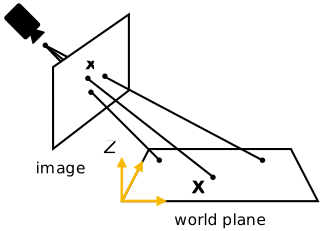
  <div style="text-align:center;">
  <img src="../images/homography/image-ground-projection.png", width="400px" />
  <figcaption>A homography provides an invertible transformation between the homogeneous coordinates of points in two planes.</figcaption>
  </div>
</figure>

Consider the scenario above in which the world is planar and consists of a collection of points $\mathbf{X}_i, \; i \in \{1,2,\ldots,n\}$, expressed in homogeneous coordinates. These points project to points $\mathbf{x}_i$ in an image of the scene. We can relate each point-pair according to the camera projection matrix

$$
\mathbf{x}_i = 
\begin{bmatrix}
f_x & 0 & p_x\\
0 & f_y & p_y\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\mathbf{R} \; \vert \; \mathbf{t}
\end{bmatrix} \mathbf{X}_i
$$

where $\mathbf{R}$ and $\mathbf{t}$ are the rotation matrix and translation vector, respectively, that define the transformation from the world frame to the camera frame. Since we are free to define the world frame as we see fit, let's define it such that the world plane lies in the $x-y$ plane with the $z$-axis orthogonal and pointing up. We can then write the projection operation as follows:

$$
\begin{align}
\mathbf{x}_i &= 
\begin{bmatrix}
f_x & s & p_x\\
0 & f_y & p_y\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
R_{11} & R_{12} & R_{13} & t_x\\
R_{21} & R_{22} & R_{23} & t_y\\
R_{31} & R_{32} & R_{33} & t_z\\
\end{bmatrix} 
\begin{bmatrix}
X_i\\
Y_i\\
Z_i\\
1
\end{bmatrix}\\
&= 
\begin{bmatrix}
f_x & 0 & p_x\\
0 & f_y & p_y\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
R_{11} & R_{12} & R_{13} & t_x\\
R_{21} & R_{22} & R_{23} & t_y\\
R_{31} & R_{32} & R_{33} & t_z\\
\end{bmatrix} 
\begin{bmatrix}
X_i\\
Y_i\\
0\\
1
\end{bmatrix} \quad \textrm{since } Z_i = 0\\
&=
\begin{bmatrix}
f_x & 0 & p_x\\
0 & f_y & p_y\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
R_{11} & R_{12} & t_x\\
R_{21} & R_{22} & t_y\\
R_{31} & R_{32} & t_z\\
\end{bmatrix} 
\begin{bmatrix}
X_i\\
Y_i\\
1
\end{bmatrix}\\
&=
\begin{bmatrix}
H_{11} & H_{12} & H_{13}\\
H_{21} & H_{22} & H_{23}\\
H_{31} & H_{32} & H_{33}\\
\end{bmatrix} 
\begin{bmatrix}
X_i\\
Y_i\\
1
\end{bmatrix}
\end{align}
$$

The matrix $H$ defines a projective transformation and is referred to as a *homography*. The matrix is full-rank and defines an invertible mapping between points in the world and their corresponding projection in the image, i.e.,

$$ 
\begin{align}
\mathbf{x}_i &= H 
\begin{bmatrix}
X_i\\
Y_i\\
1
\end{bmatrix}\\
\begin{bmatrix}
X_i\\
Y_i\\
1
\end{bmatrix} &= H^{-1} \mathbf{x}_i
\end{align}
$$

Since we can multiply $H$ by any non-zero constant without affecting the transformation, it has 8 degrees-of-freedom.

**Example: Exploring a Homography**

Homographies define a projection from one plane to another. Above, we described this in the context of a projection $H$ from points that lie on a plane in the world to the image plane for a particular camera pose. The homography provides a one-to-one mapping of points in the world plane to their corresponding projection in the image. If we were to move the camera to a different pose, there would similarly be a different homography $\bar{H}$ relating the image to the ground plane.

<figure>
  <div style="text-align:center;">
  <img src="../images/homography/image-ground-image-projection.png", width="600px" />
  <figcaption>A visualization of a simple pinhole camera.</figcaption>
  </div>
</figure>

We can compose these homographies to get a homography that relates the homogeneous coordinates of points in one image to their corresponding coordinates in the second image.

$$
\begin{align}
\mathbf{x}_i &= H \mathbf{X}_i\\
&= H\left(\bar{H}^{-1}\mathbf{x}^\prime_i\right)\\
&= \left(H\bar{H}^{-1}\right)\mathbf{x}^\prime_i\\
&= \check{H}\mathbf{x}^\prime_i
\end{align}
$$

where $\check{H} = H\bar{H}^{-1}$ is the homography between the two images that is induced by the ground plane.

In this example, you will explore the use of a homography to relate images of the same scene taken from different poses. While the scene is not planar, there are planes (e.g., the floor) that were used to induce the homography between views.

<figure>
  <div style="text-align:center;">
  <img src="../images/homography/bt.000.png", width=400px>
  <img src="../images/homography/bt.002.png", width=400px>
  <figcaption>Two images of a hallway on the Oxford campus taken from different viewpoints. The planar ground induces a homography $\check{H}$ between the two images.</figcaption>
  </div>
</figure>

In [1]:
### Run this cell to import relevant modules
%load_ext autoreload
%autoreload 2
%matplotlib tk
%pylab tk

from matplotlib import pyplot as plt
import numpy as np
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
# TODO: Running this cell will bring up a figure displaying the two above images of the scene. When you click a point in the left image,
#.      the projected point in the right image will be rendered according to the homography induced by the ground plane.
#.      Compare the accuracy of the correspondences for points that lie on the ground plane to points elsewhere in the environment.
imgl = cv2.imread('../images/homography/bt.000.png', 0)
imgr = cv2.imread('../images/homography/bt.002.png', 0)

H = np.array([[0.907503833504229, -0.116496578881938, 30.8471918181923],[0.00308072860216055, 0.828815989469247, 16.0448537015201],[-1.74015013507422e-05, -0.000441721032603193, 1]])

fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imgl,cmap = 'gray')
ax1.set_title('Source Image');
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(imgr,cmap = 'gray')
ax2.set_title('Target Image');

def onclick(event):
    # Apply the homography
    x = np.array([[event.xdata, event.ydata, 1]]).transpose()
    xprime = H.dot(x)
    xprime = xprime/xprime[2]
    
    # Visualize the selected and projected points
    ax1.plot(x[0], x[1], 'rx')
    ax2.plot(xprime[0], xprime[1], 'rx')
    plt.show()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

You can now move to the [camera calibration tutorial](../03-Camera-Calibration/camera_calibration.ipynb).